# Plotting Functions

In [1]:
from pathlib import Path
from constants import SCORED_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from treatment_effects import calculate_treatment_effects
from utils_plotting import create_latex_tables_from_samples, plot_scores, naive_vs_RATE, rewrite_bias, synthetic_subplots, att_atu
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

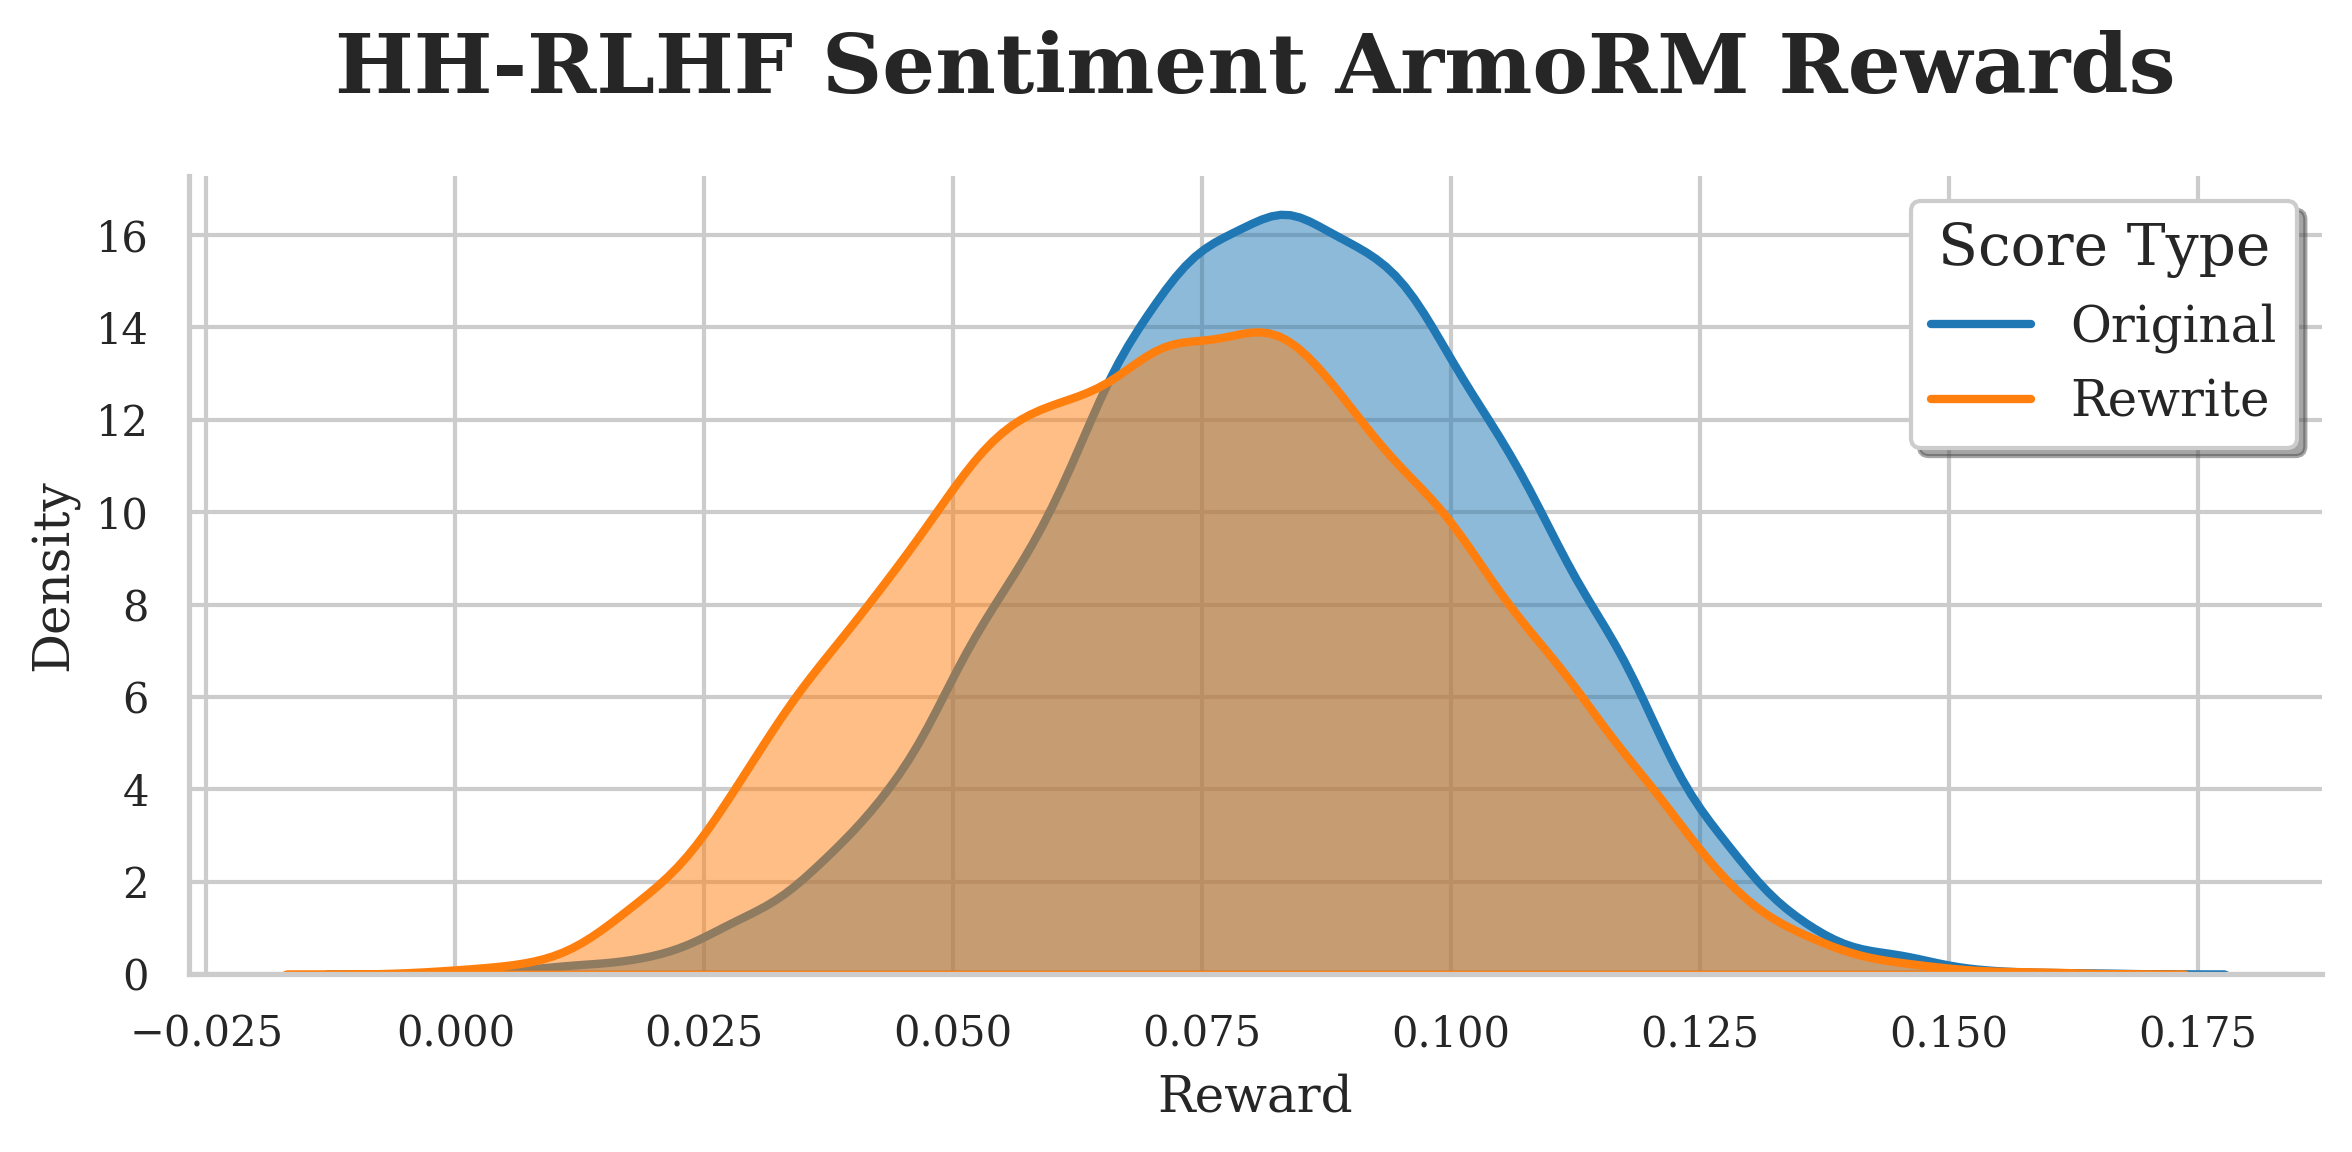

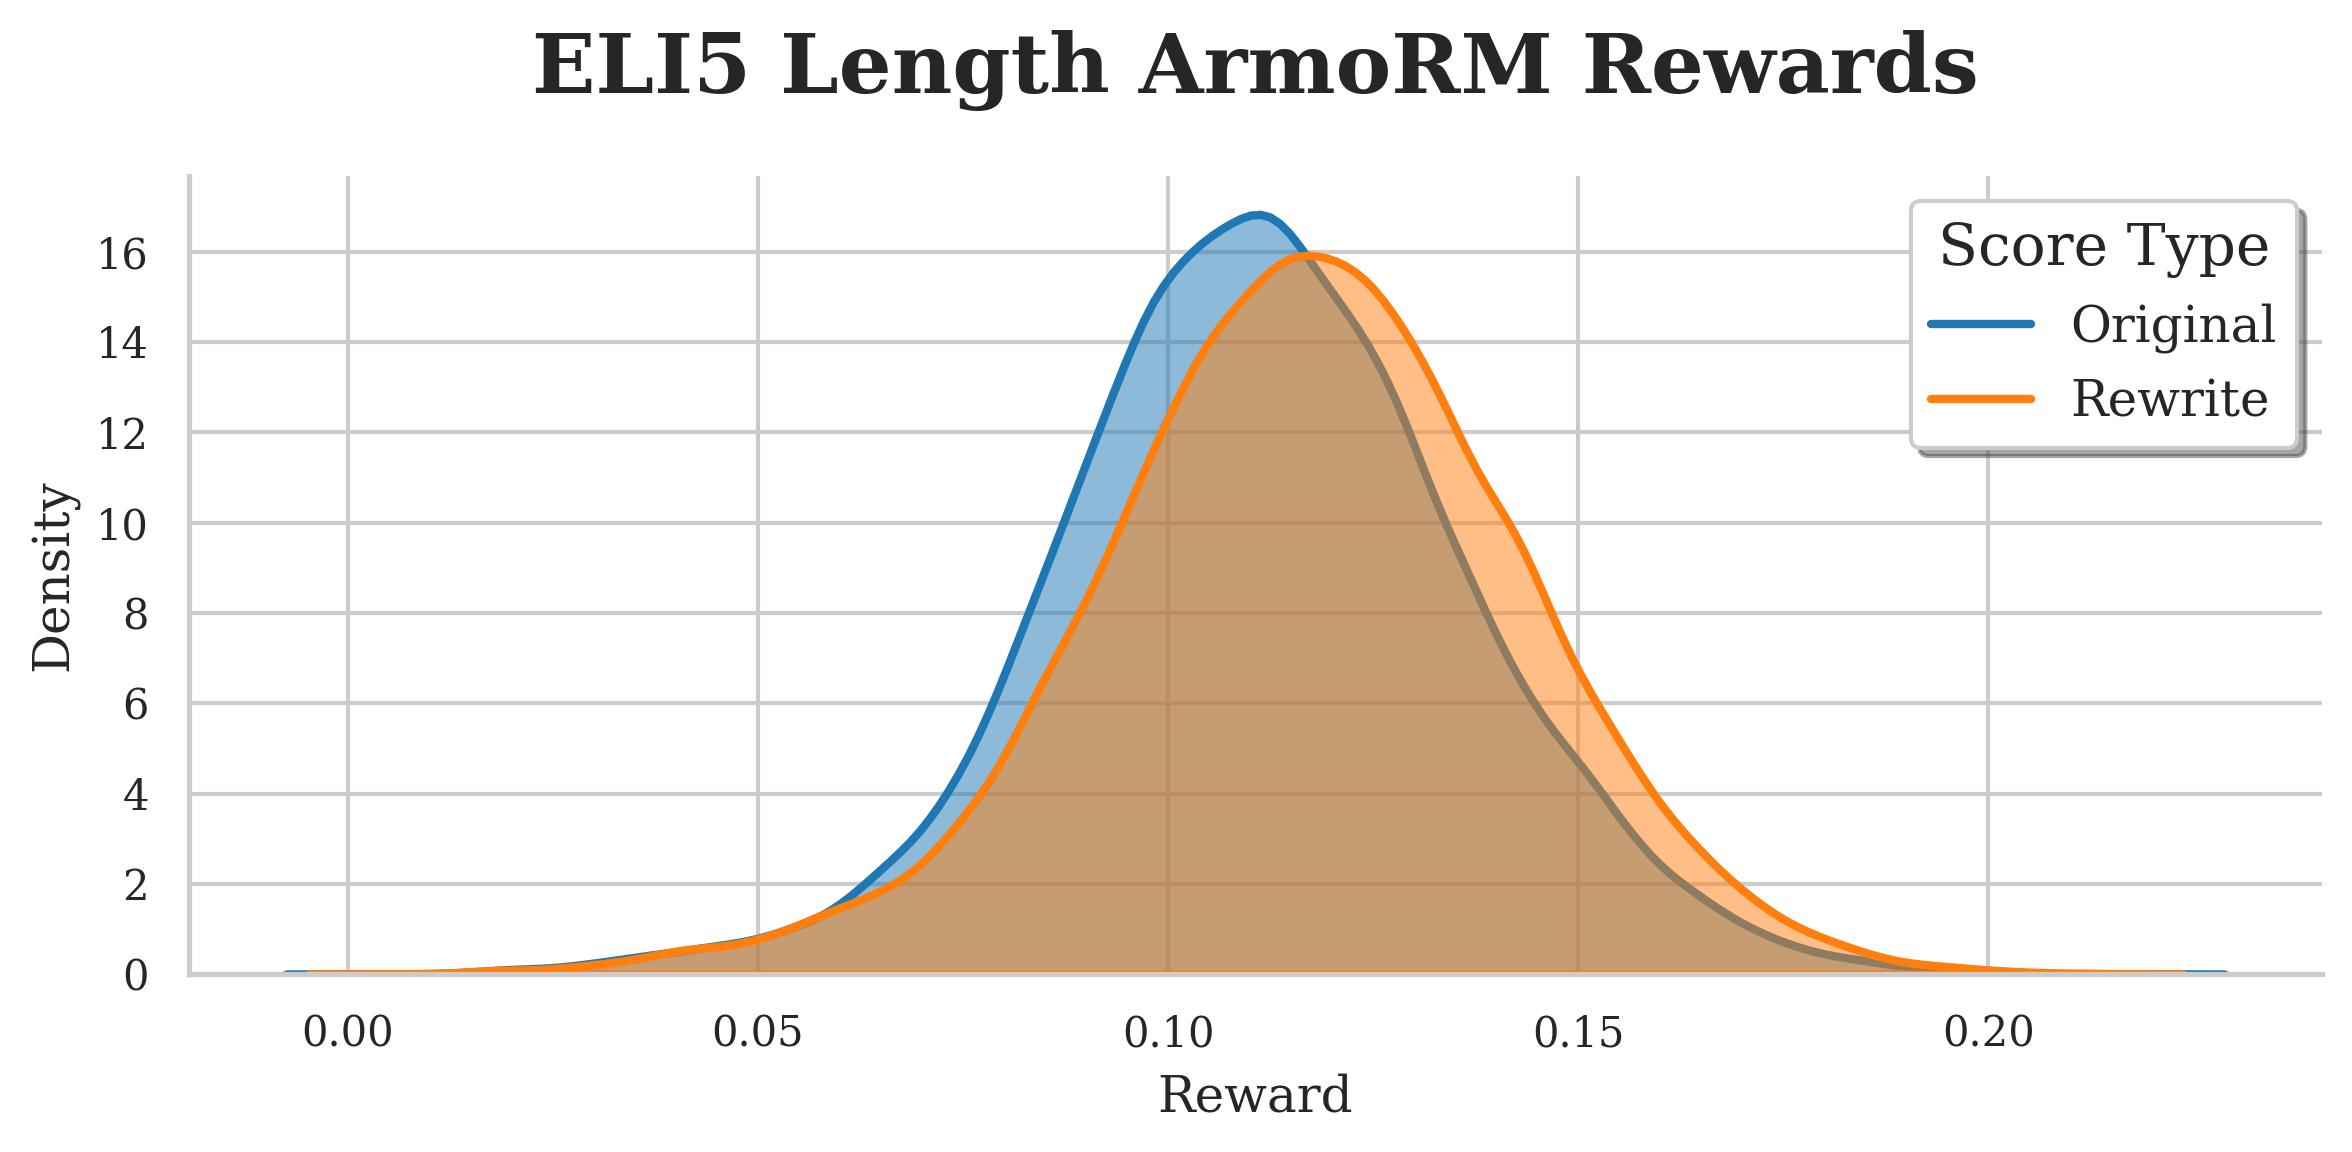

In [2]:
hh_rlhf_template = {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
eli5_template = {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    }

plot_scores(hh_rlhf_template, SCORED_DIR)
plot_scores(eli5_template, SCORED_DIR)

In [3]:
config = load_dataset_from_json(Path("config_plotting.jsonl"))

# make into list of dictionaries
experiment_templates = [value for value in config.values()]

In [ ]:
# save all the data
effects_data = []
for effects_template in experiment_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    effects_data.append(effects)

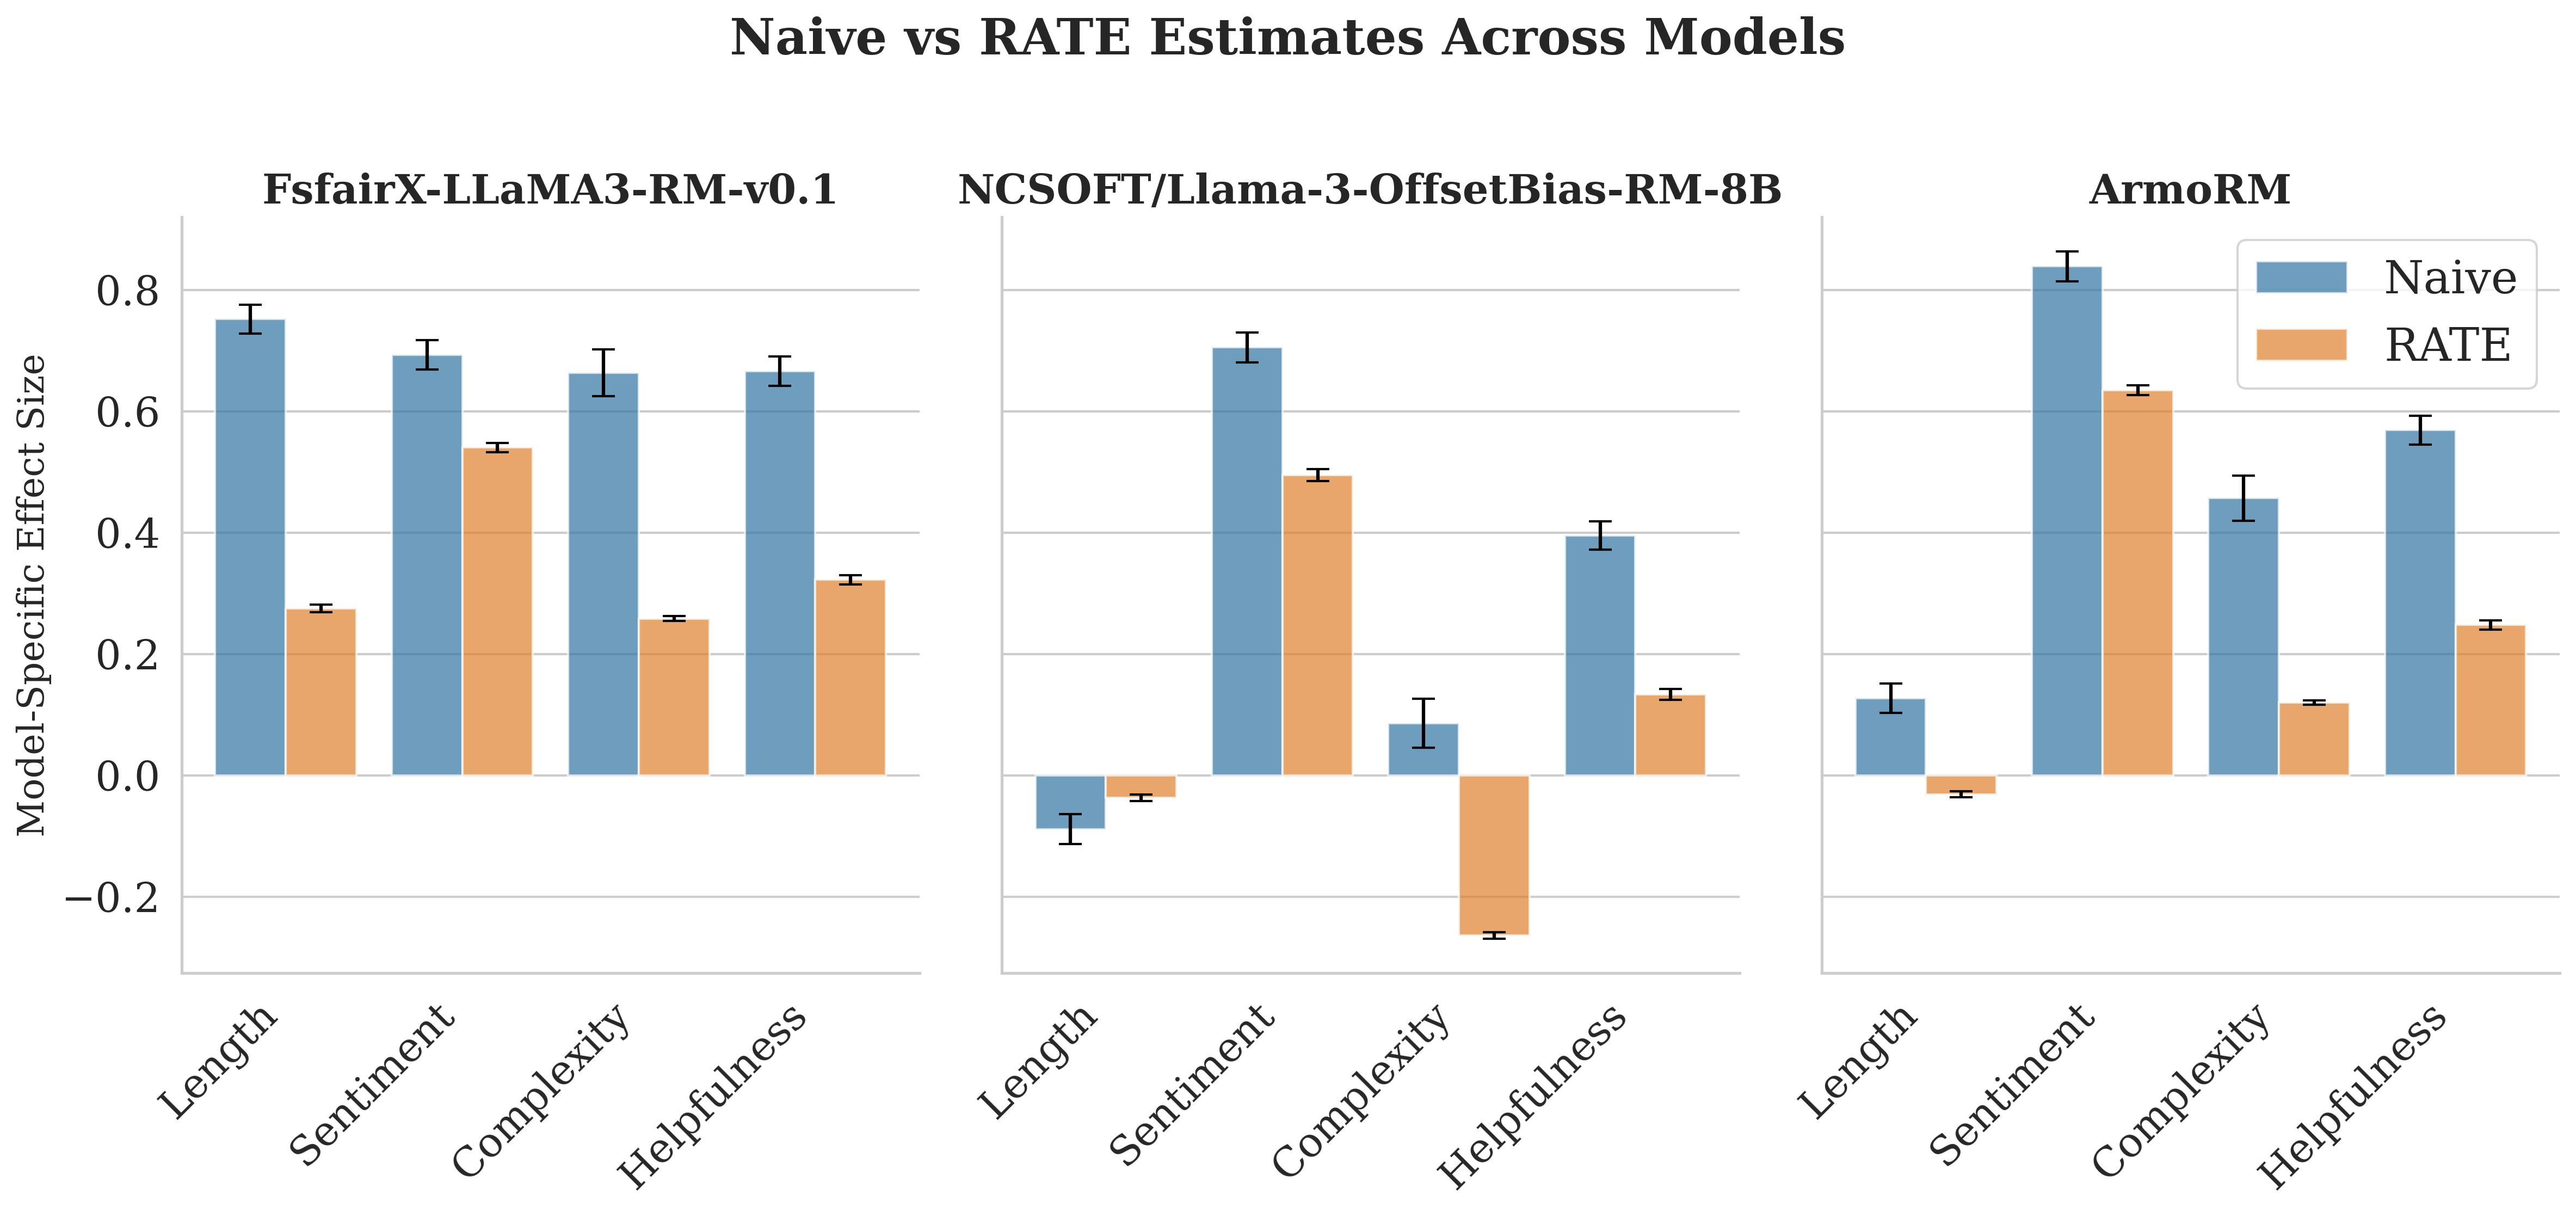

In [5]:
reward_models = ['FsfairX-LLaMA3-RM-v0.1', 'NCSOFT/Llama-3-OffsetBias-RM-8B', 'ArmoRM']
naive_vs_RATE(effects_data, experiment_templates, reward_models, normalize = 'reward_std')

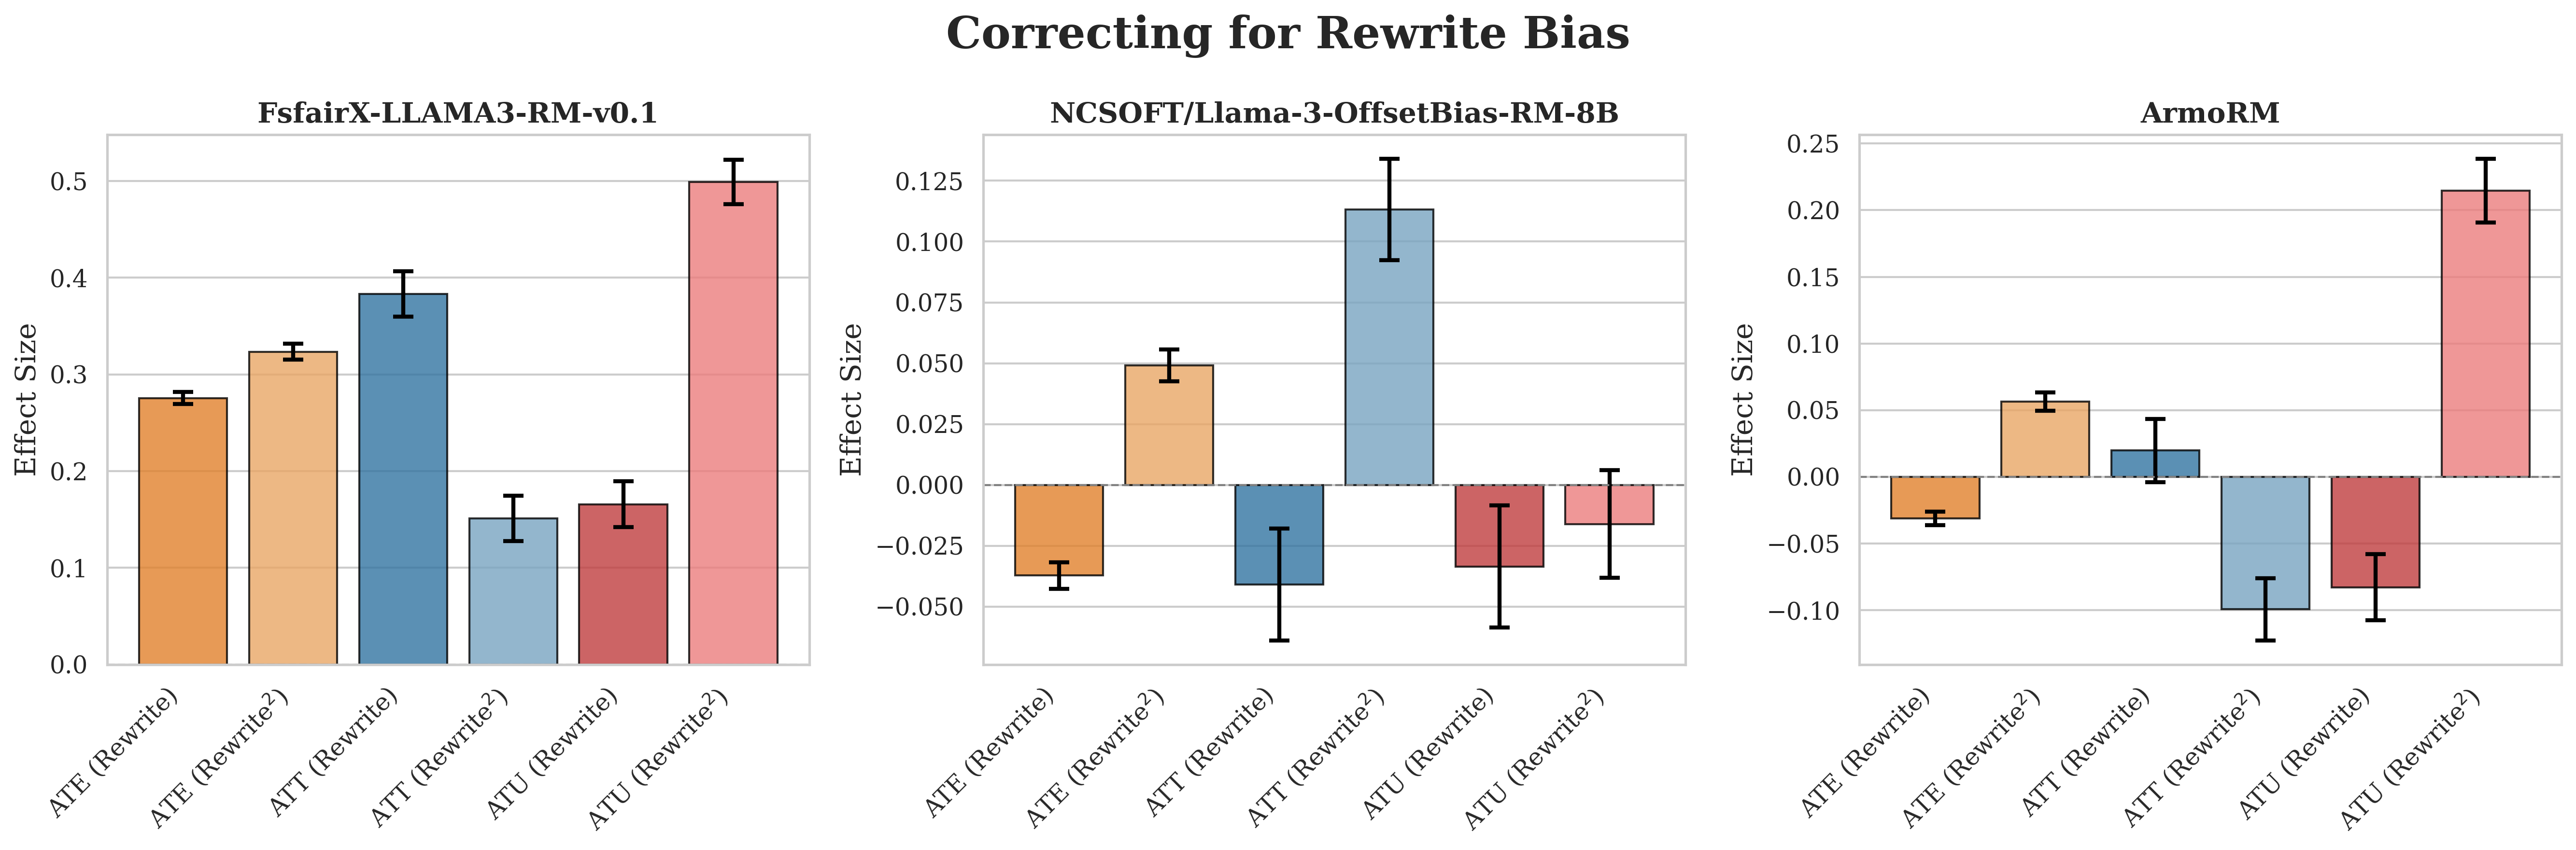

In [6]:
# reverse effects_data[0:3]
reversed_data = effects_data[0:3][::-1]
rewrite_bias(reversed_data)

In [7]:
config = load_dataset_from_json(Path("config_plotting_synth.jsonl"))

# make into list of dictionaries
synthetic_templates = [value for value in config.values()]

In [ ]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    synthetic_data.append(effects)

In [9]:
config = load_dataset_from_json(Path("config_plotting_help_synth.jsonl"))

# make into list of dictionaries
help_synthetic_templates = [value for value in config.values()]

In [ ]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    help_synthetic_data.append(effects)

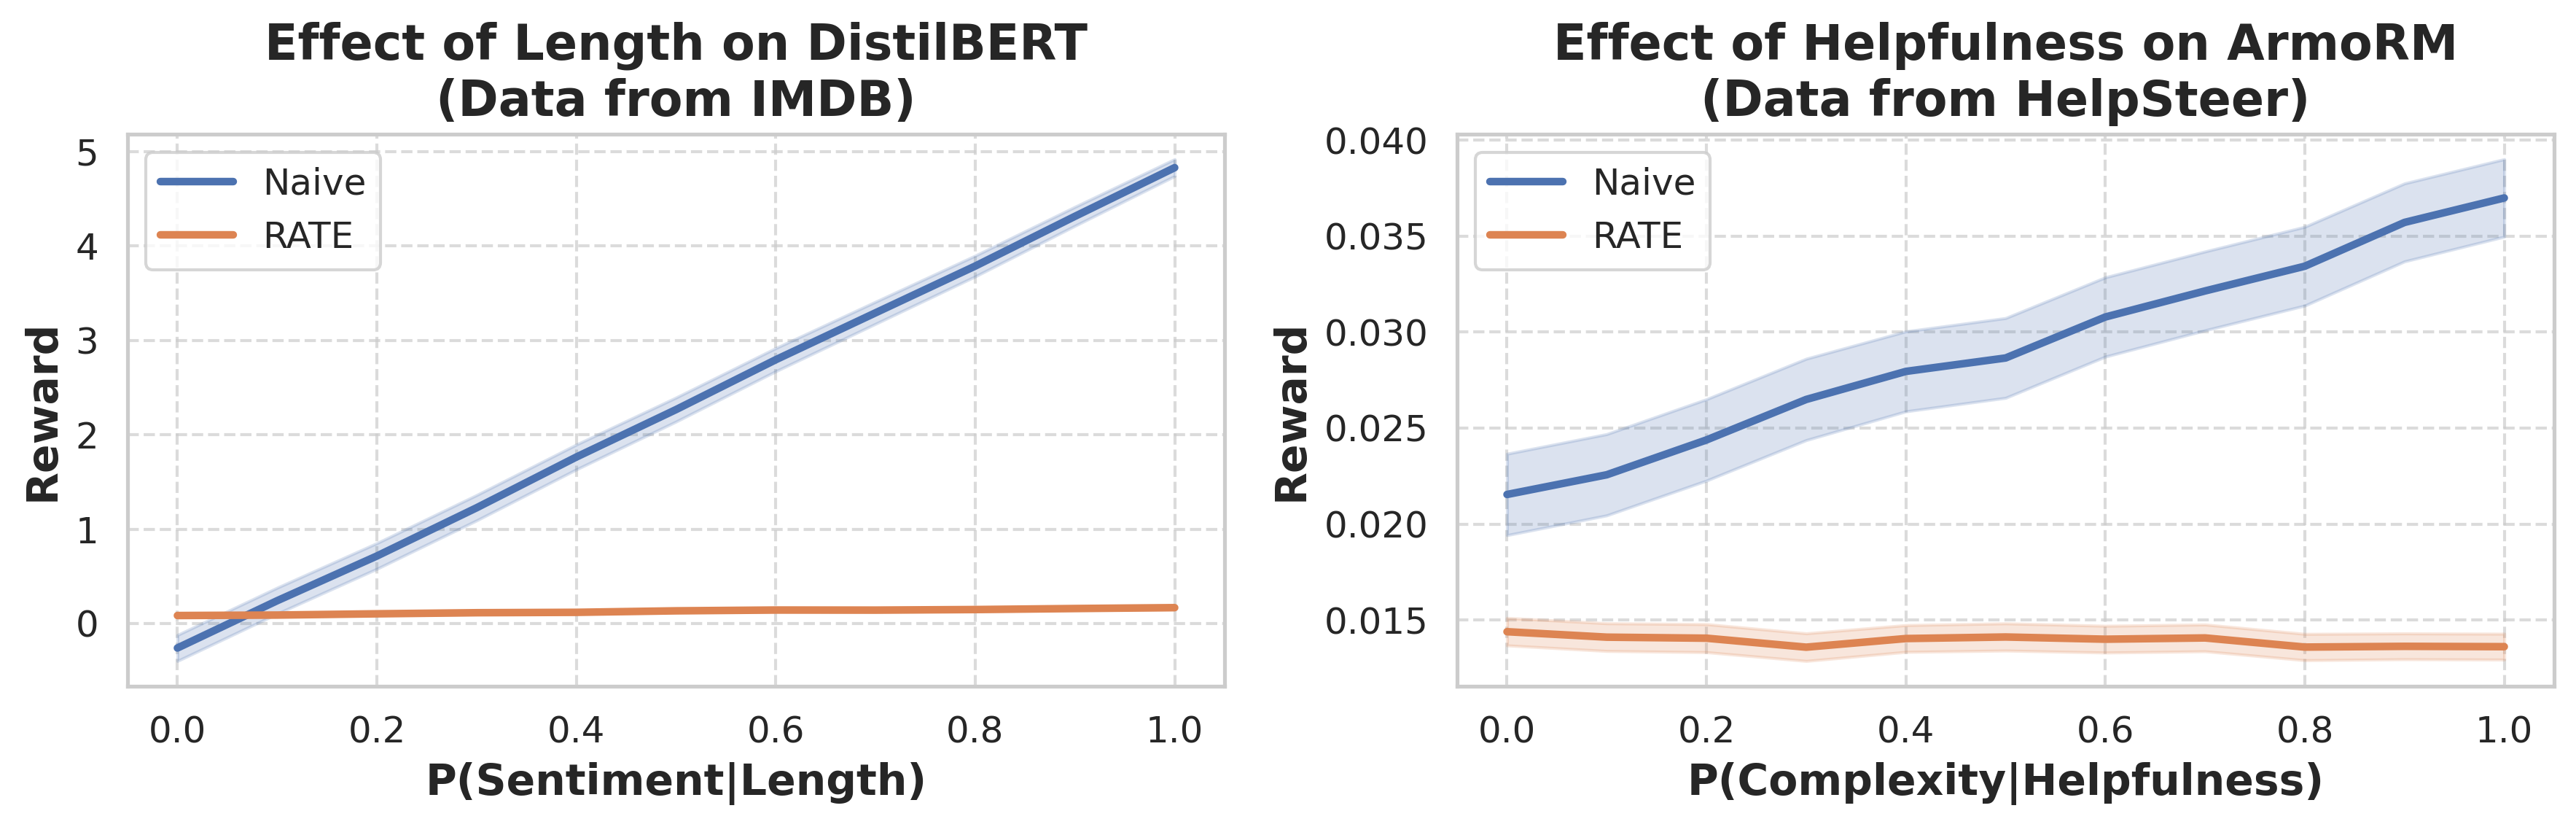

In [11]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")

Next we compare the RATE ATT vs ATU estimates for a particular tuple, also normalized.

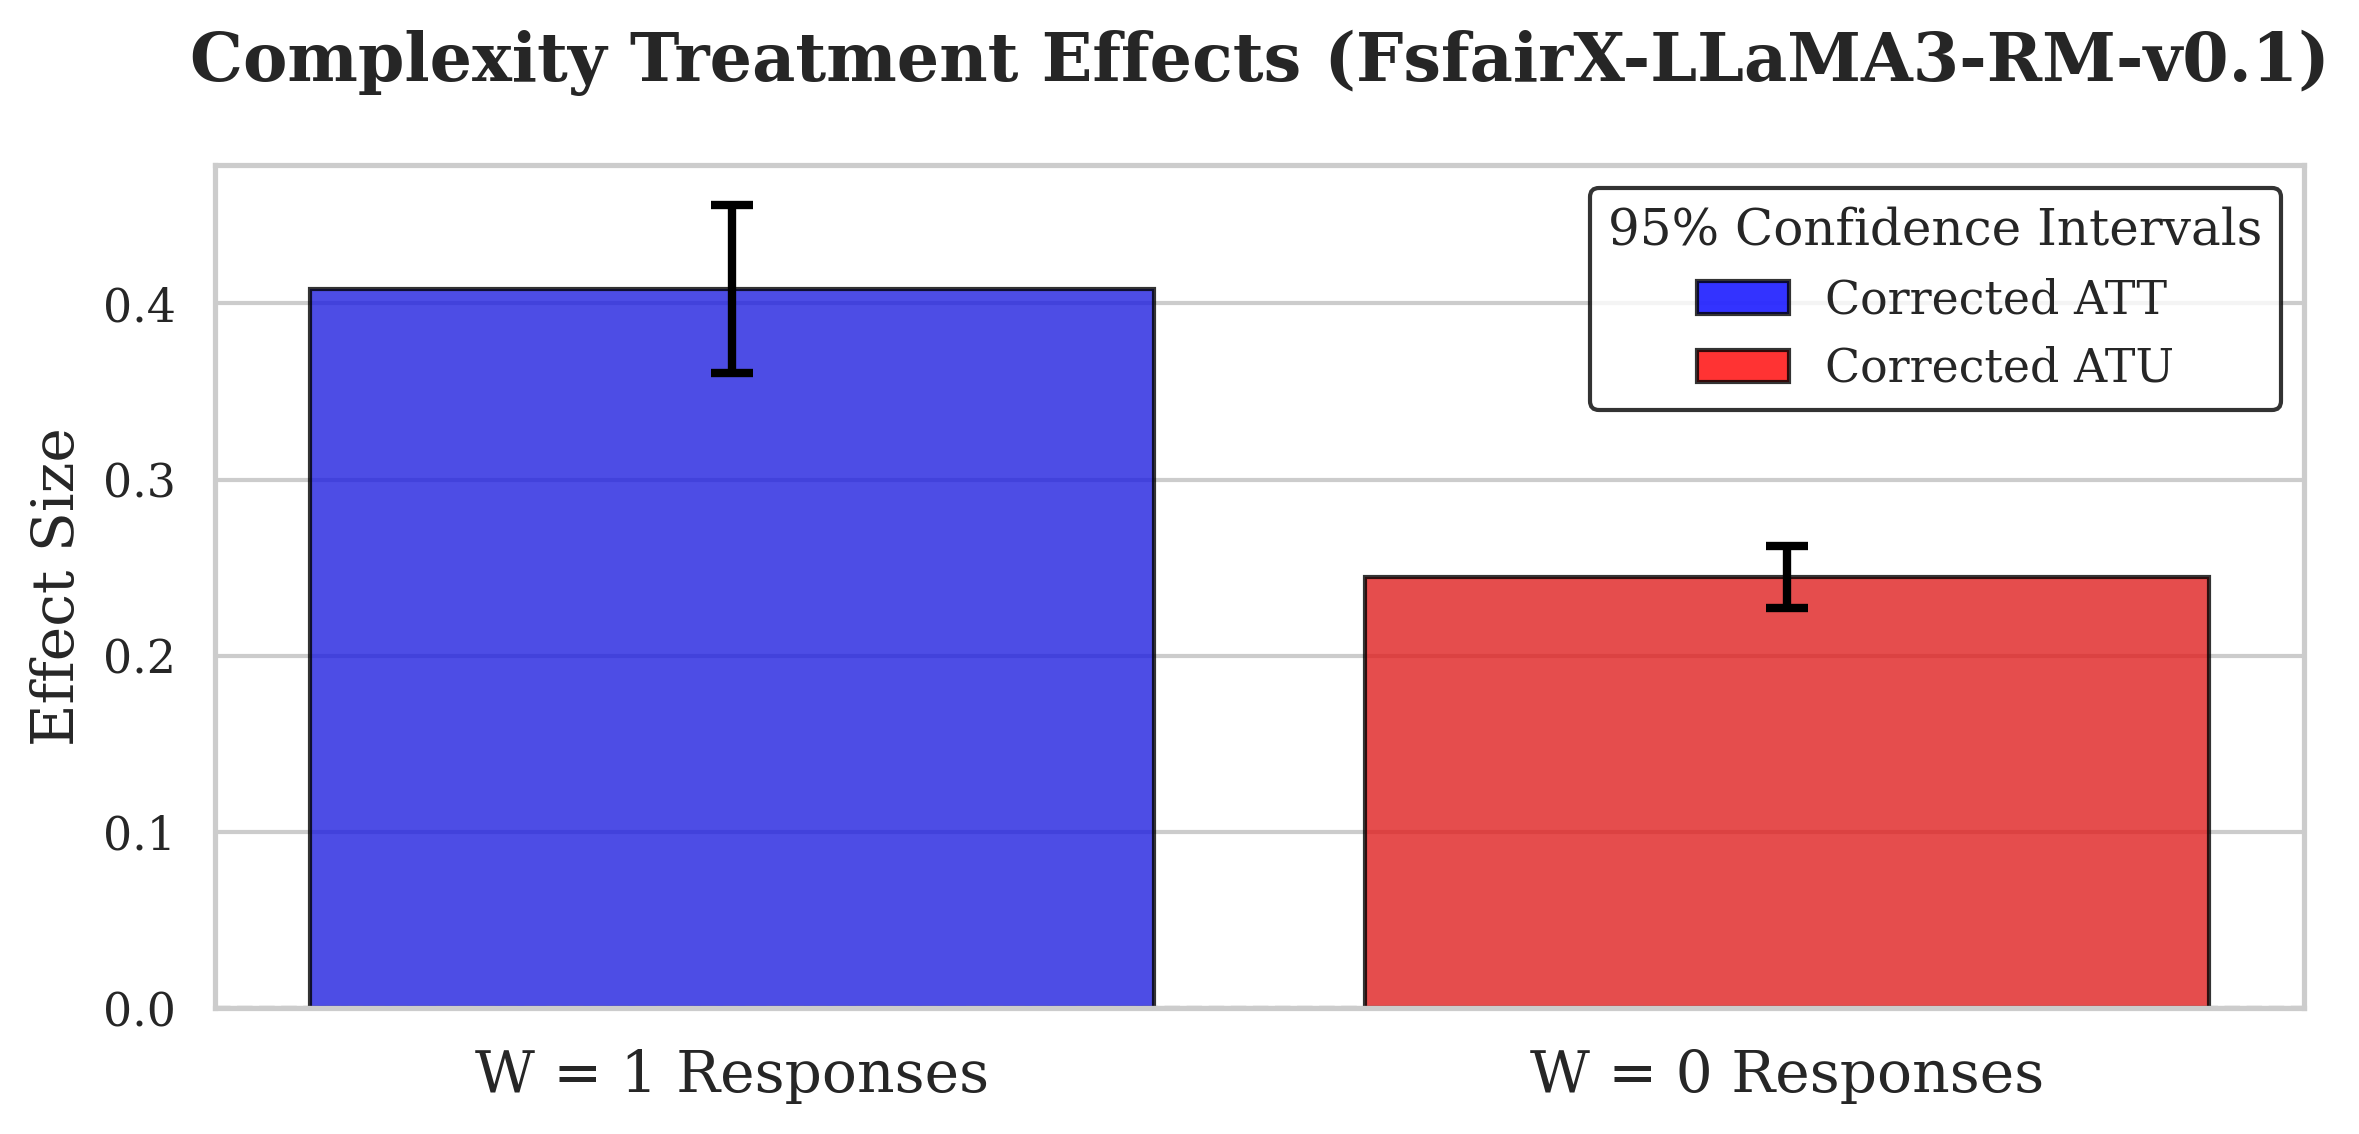

In [12]:
att_atu(effects_data[8], effects_data[8]['reward_std'])